# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os

from bart_playground.bandit.sim_util import *
from compare_agents import (
    compare_agents_across_scenarios, print_summary_results, plot_comparison_results,
    class_to_agents # Import class_to_agents
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

2025-06-13 16:38:31,279	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Create test scenarios
np.random.seed(0)
    
scenarios = {
    #"Linear": LinearScenario(P=4, K=3, sigma2=1.0),
    #"LinearOffset": LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    #"Offset": OffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset2": OffsetScenario(P=4, K=3, sigma2=0.1),
    # "Friedman": FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=15),
    # "Sparse": FriedmanScenario(P=50, K=3, sigma2=1.0, lambda_val=5),
    "OpenML": OpenMLScenario('mushroom') # NeuralScenario('mushroom'),
}

np.random.seed(0)

# import torch
# torch.manual_seed(0)
# torch.cuda.manual_seed_all(42)

In [3]:
# Define experiment parameters
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
# from bart_playground.bandit.neural_ts_agent import NeuralTSDiagAgent

import multiprocessing

from bart_playground.bart import LogisticBART

cores =  multiprocessing.cpu_count() - 1

n_simulations = 1  # Number of simulations per scenario
n_draws = 800      # Number of draws per simulation

def call_func():
    return(compare_agents_across_scenarios(
        scenarios=scenarios,
        n_simulations=n_simulations,
        n_draws=n_draws,
        agent_classes=[LinearTSAgent, LinearTSAgent2, MultiChainBARTAgent], # LogisticBARTAgent], # NeuralTSDiagAgent], #, EnsembleAgent], #, BCFAgentPSOff], # LinearUCBAgent, METSAgent, HierTSAgent],
        agent_names=["LinearTS", "LinearTS2", "MultiChainBART"], #, "Neural"], #, "MBCF+Linear"] #, "METS", "HierTS"],
        n_jobs=1 # min(n_simulations, cores),  # Use all available cores or the number of simulations, whichever is smaller
    ))

In [4]:
from bart_playground.samplers import Sampler
from bart_playground.bandit.sim_util import simulate
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.sim_util import Scenario
# %load_ext memory_profiler
# %mprun -f BCFAgent.update_state call_func()

In [5]:
# %prun -s cumtime -D profile_bartts.prof -q call_func()
# !gprof2dot -f pstats profile_bartts.prof -o profile_bartts.dot
# !dot -Tpng profile_bartts.dot -o profile_bartts.png

In [6]:
results = call_func()


Evaluating OpenML scenario...
Running a single simulation...


2025-06-13 16:38:35,432	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Created 4 BARTActor(s) using BART class: LogisticBART


Simulating: 100%|██████████| 800/800 [02:24<00:00,  5.53it/s]


## Summary Results

In [7]:
print_summary_results(results)


=== OpenML Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 196.00 (±0.00)
  LinearTS2: 182.00 (±0.00)
  MultiChainBART: 69.00 (±0.00)

Average computation times (seconds):
  LinearTS: 0.1513 (±0.0000)
  LinearTS2: 0.4970 (±0.0000)
  MultiChainBART: 143.4559 (±0.0000)



## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [8]:
# Create results directory if it doesn't exist
results_dir = "./results/agent_comparison_new"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import pickle

result_filename = os.path.join(results_dir, f"result.pkl")

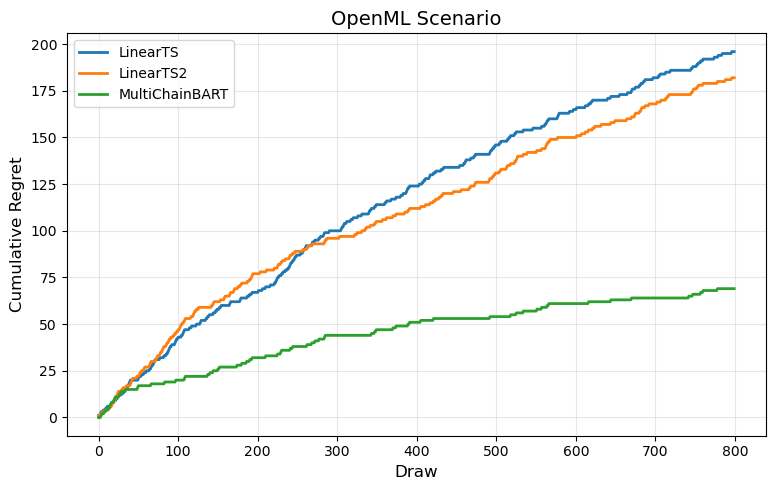

In [9]:
# import pickle
# results_dir = "./results/agent_comparison5"
# result_filename = os.path.join(results_dir, f"result.pkl")
# results, n_draws = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    n_draws=n_draws,
    save_path=f"{results_dir}/agent_comparison_results_logMC.png",
    show_time=False
)